In [1]:
import numpy as np
import cv2 as cv

In [2]:
# delete all files in data folder
import os
import shutil

folder = "data"
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print("Failed to delete %s. Reason: %s" % (file_path, e))

# create folders
os.mkdir("data/circles")
os.mkdir("data/squares")
os.mkdir("data/triangles")

# generate images
n_images = 10

# generate random radius and center
radius = np.random.randint(3, 8, n_images)
center = np.random.randint(5, 27, (n_images, 2))
color = np.random.randint(100, 255, (n_images, 3))
thick = np.random.randint(1, 2, n_images)

# generate 32x32 images of circles
for i in range(n_images):
    img = np.zeros((32, 32, 3), dtype="uint8")
    ccrd = center[i]
    r = radius[i]
    co = [int(a) for a in color[i]]
    t = thick[i]
    cv.circle(img, tuple(ccrd), r, co, t)
    # save image
    cv.imwrite(f"data/circles/{i:05d}.png", img)

# generate 32x32 images of squares
for i in range(n_images):
    img = np.zeros((32, 32, 3), dtype="uint8")
    ccrd = center[i]
    r = int(radius[i]*1.3)
    co = [int(a) for a in color[i]]
    t = thick[i]
    cv.rectangle(img, (ccrd[0]-r, ccrd[1]-r), (ccrd[0]+r, ccrd[1]+r), co, t)
    # save image
    cv.imwrite(f"data/squares/{i:05d}.png", img)

# generate 32x32 images of triangles
for i in range(n_images):
    img = np.zeros((32, 32, 3), dtype="uint8")
    ccrd = center[i]
    r = int(radius[i]*1.5)
    co = [int(a) for a in color[i]]
    t = thick[i]
    cv.line(img, (ccrd[0]-r, ccrd[1]-r), (ccrd[0]+r, ccrd[1]-r), co, t)
    cv.line(img, (ccrd[0]+r, ccrd[1]-r), (ccrd[0], ccrd[1]+r), co, t)
    cv.line(img, (ccrd[0], ccrd[1]+r), (ccrd[0]-r, ccrd[1]-r), co, t)
    # save image
    cv.imwrite(f"data/triangles/{i:05d}.png", img)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [4]:
dataset = torchvision.datasets.ImageFolder(root='data', transform=transforms.ToTensor())
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

torch.Size([1, 3, 32, 32]) tensor([1])


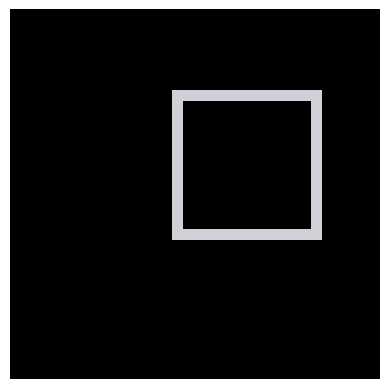

In [5]:
for image, label in dataset_loader:
    print(image.shape, label)
    # display image
    plt.imshow(image[0].permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

In [7]:
# define a FC network 32x32 to 3 classes
class ShapeNet(nn.Module):
    def __init__(self, hidden_size=100):
        super(ShapeNet, self).__init__()
        self.fc1 = nn.Linear(32*32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x